In [1]:
import json

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 20)

In [3]:
import utils.checker as check
import utils.presenter as show
import utils.schedule_solver__with_arrivals as ssv

import utils.converter as convert

In [4]:
import utils.rolling_planning as rp

In [5]:
from ProductionDaySimulation import ProductionDaySimulation

In [6]:
import utils.schedule_solver__rescheduling as re_ssv

In [7]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [8]:
minutes = 50

## Day 0

In [9]:
jssp_data, df_times = rp.init_jobs_with_arrivals(instance, 3, u_b_mmax = 0.75, 
                                                    generate_deadlines = True, deadlines_buffer_factor= 1.9)
show.print_jobs(jssp_data)

Job_000:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_001:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_002:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_003:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_004:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_005:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_006:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_007:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_008:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_009:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 4

In [10]:
df_times 

,Job,Arrival,Deadline
0,Job_000,14.37,2362.556555
1,Job_001,116.28,3148.115805
2,Job_002,141.78,3518.412818
3,Job_003,192.34,4086.168337
4,Job_004,236.45,2572.747002
...,...,...,...
64,Job_064,3749.15,6085.447002
65,Job_065,3907.00,7111.234311
66,Job_066,4061.64,6409.826555
67,Job_067,4110.12,7141.955805


### 1) Scheduling

In [11]:
df_plan0, total = ssv.solve_jssp_weighted_individual_flowtime(jssp_data, df_times, solver_time_limit= 60*minutes, epsilon=0.06)
check.check_all_constraints(df_plan0, jssp_data)

Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 3000
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/b60e9978710b422baab14c9f04592e55-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/b60e9978710b422baab14c9f04592e55-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 23460
MIP  b60e9978710b422baab14c9f04592e55-pulp has 47679 rows; 24219 cols; 142209 nonzeros; 23460 integer variables (23460 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [2e-04, 7e-02]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
47541 rows, 24150 cols, 142002 nonzeros  0s
24081 rows, 24150 cols, 71622 nonzeros  0s
24081 rows, 24150 cols, 71622 nonzeros  0s

Solving MIP model with:
   24081 rows
   24150 cols (23460 binary, 0 integer, 0 implied int., 690 continuous)
   71622 nonzeros

Src: B => Branching; C => Cent

True

In [12]:
print(f"Globale Makespan:{max(df_plan0.End)}")
df_plan0

Globale Makespan:7116.36


,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_068,4210.59,M1,6074.00,91,1954.41,6165.00
1,Job_068,4210.59,M0,6357.18,85,2231.59,6442.18
2,Job_068,4210.59,M3,6724.36,39,2552.77,6763.36
3,Job_068,4210.59,M2,6763.36,74,2626.77,6837.36
4,Job_068,4210.59,M8,6837.36,90,2716.77,6927.36
...,...,...,...,...,...,...,...
685,Job_000,14.37,M5,215.37,11,212.00,226.37
686,Job_000,14.37,M6,226.37,62,274.00,288.37
687,Job_000,14.37,M7,288.37,56,330.00,344.37
688,Job_000,14.37,M8,344.37,44,374.00,388.37


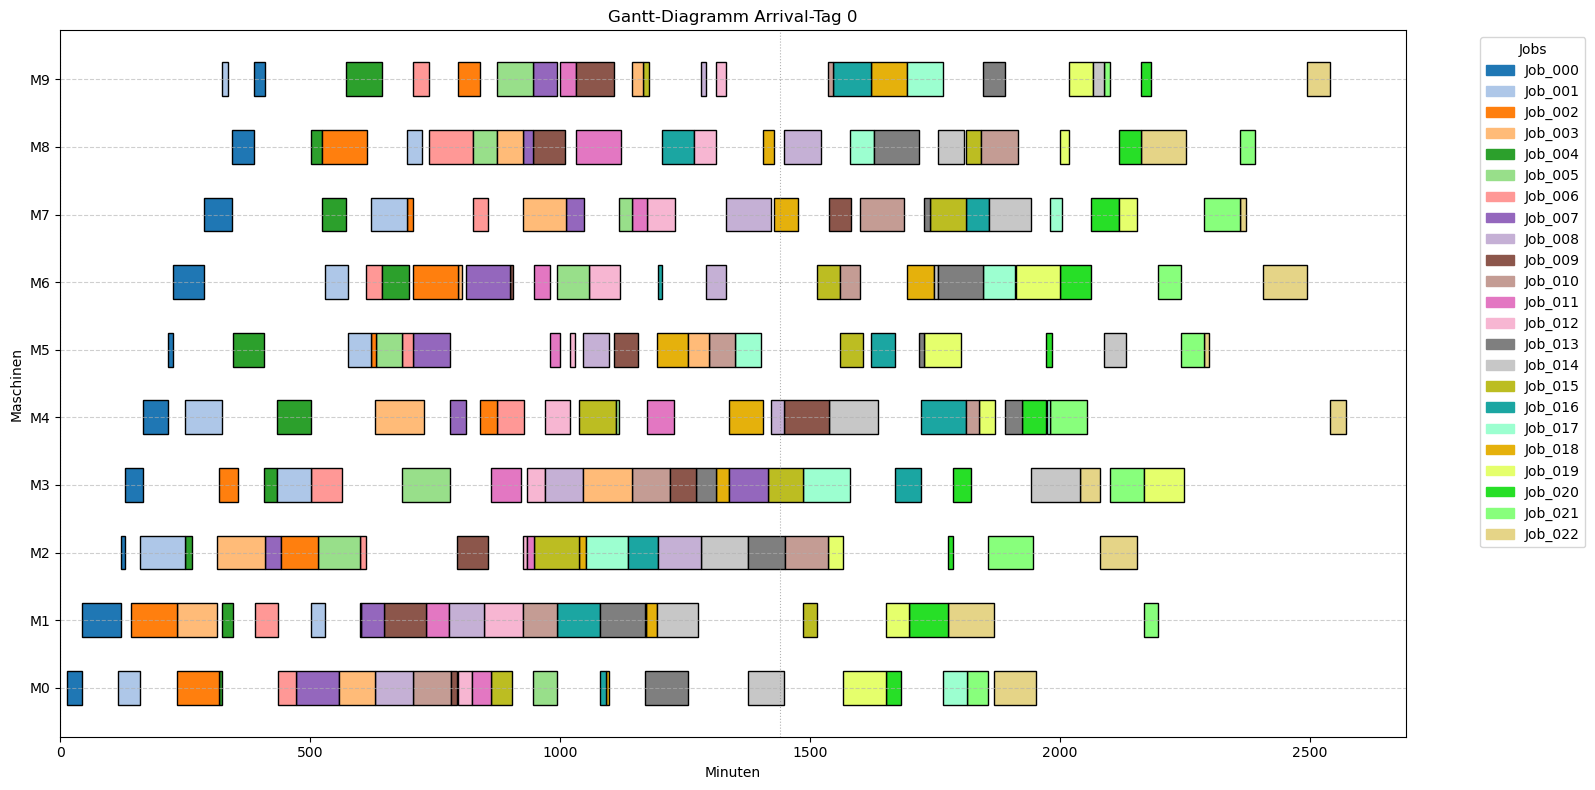

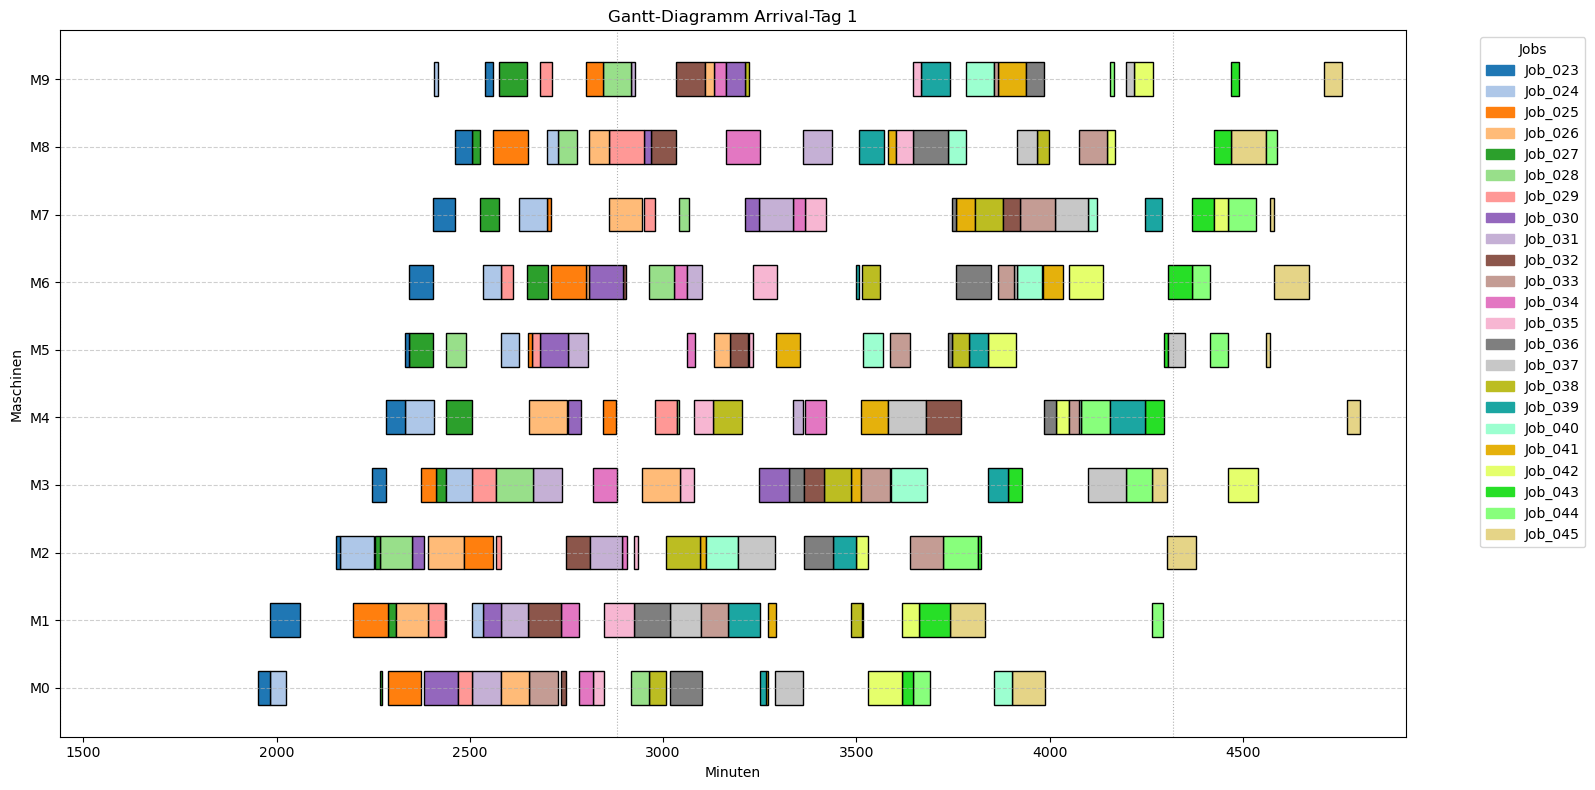

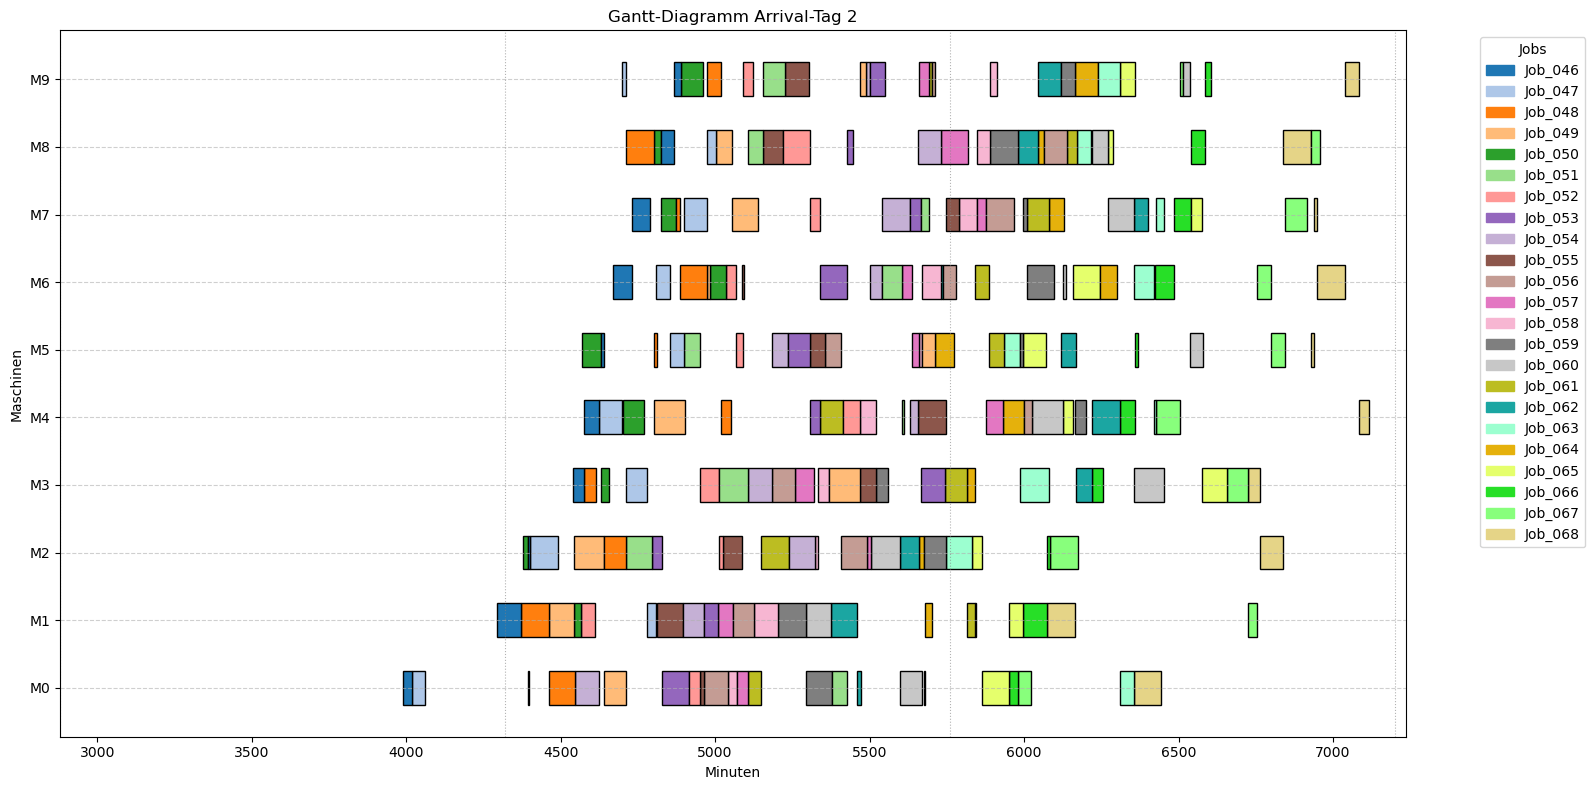

In [13]:
df = df_plan0

block = 1440                                        
for idx, part_df in df.groupby(df['Arrival'] // block, sort=True):
    show.plot_gantt_machines(part_df, f"Gantt-Diagramm Arrival-Tag {int(idx)}")

### 2) Simulation für Tag 0

In [14]:
day_start = 0
day_end = 1440

filt = (df_plan0["Start"] >=  day_start) & (df_plan0["Start"] < day_end)
df_schedule_0 = df_plan0[filt]
df_schedule_0

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
500,Job_018,869.15,M2,1037.52,14,182.37,1051.52
501,Job_018,869.15,M0,1092.52,6,229.37,1098.52
502,Job_018,869.15,M1,1172.64,22,325.49,1194.64
503,Job_018,869.15,M5,1194.64,61,386.49,1255.64
504,Job_018,869.15,M3,1311.70,26,468.55,1337.70
...,...,...,...,...,...,...,...
685,Job_000,14.37,M5,215.37,11,212.00,226.37
686,Job_000,14.37,M6,226.37,62,274.00,288.37
687,Job_000,14.37,M7,288.37,56,330.00,344.37
688,Job_000,14.37,M8,344.37,44,374.00,388.37


In [15]:
simulation = ProductionDaySimulation(df_schedule_0, vc=0.25)
df_execution, df_undone = simulation.run(end_time=day_end)

[00:14:22] Job_000 started on M0
[00:36:34] Job_000 finished on M0 (after 22 minutes 13 seconds)
[00:43:22] Job_000 started on M1
[01:56:16] Job_001 started on M0
[02:13:22] Job_000 finished on M1 (after 90 minutes 01 second)
[02:13:22] Job_000 started on M2
[02:21:46] Job_002 started on M1
[02:24:17] Job_000 finished on M2 (after 10 minutes 55 seconds)
[02:24:17] Job_000 started on M3
[02:45:02] Job_000 finished on M3 (after 20 minutes 45 seconds)
[02:46:22] Job_000 started on M4
[02:53:19] Job_001 finished on M0 (after 57 minutes 03 seconds)
[02:53:19] Job_001 started on M2
[03:26:49] Job_000 finished on M4 (after 40 minutes 28 seconds)
[03:31:40] Job_002 finished on M1 (after 69 minutes 53 seconds)
[03:35:22] Job_000 started on M5
[03:44:35] Job_000 finished on M5 (after 09 minutes 13 seconds)
[03:46:22] Job_000 started on M6
[03:52:46] Job_002 started on M0
[03:52:50] Job_003 started on M1
[04:43:13] Job_001 finished on M2 (after 109 minutes 54 seconds)
[04:43:13] Job_004 started o

In [16]:
df_execution

,Job,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,14.37,M0,14.37,22.21,22.21,36.58
1,Job_000,14.37,M1,43.37,90.01,119.01,133.38
2,Job_000,14.37,M2,133.38,10.92,129.93,144.30
3,Job_000,14.37,M3,144.30,20.75,150.68,165.05
4,Job_000,14.37,M4,166.37,40.46,192.46,206.83
...,...,...,...,...,...,...,...
132,Job_017,798.47,M5,1428.84,45.75,676.12,1474.59
133,Job_018,869.15,M2,1081.82,13.24,225.91,1095.06
134,Job_018,869.15,M0,1095.06,7.68,233.59,1102.74
135,Job_018,869.15,M1,1255.87,22.44,409.16,1278.31


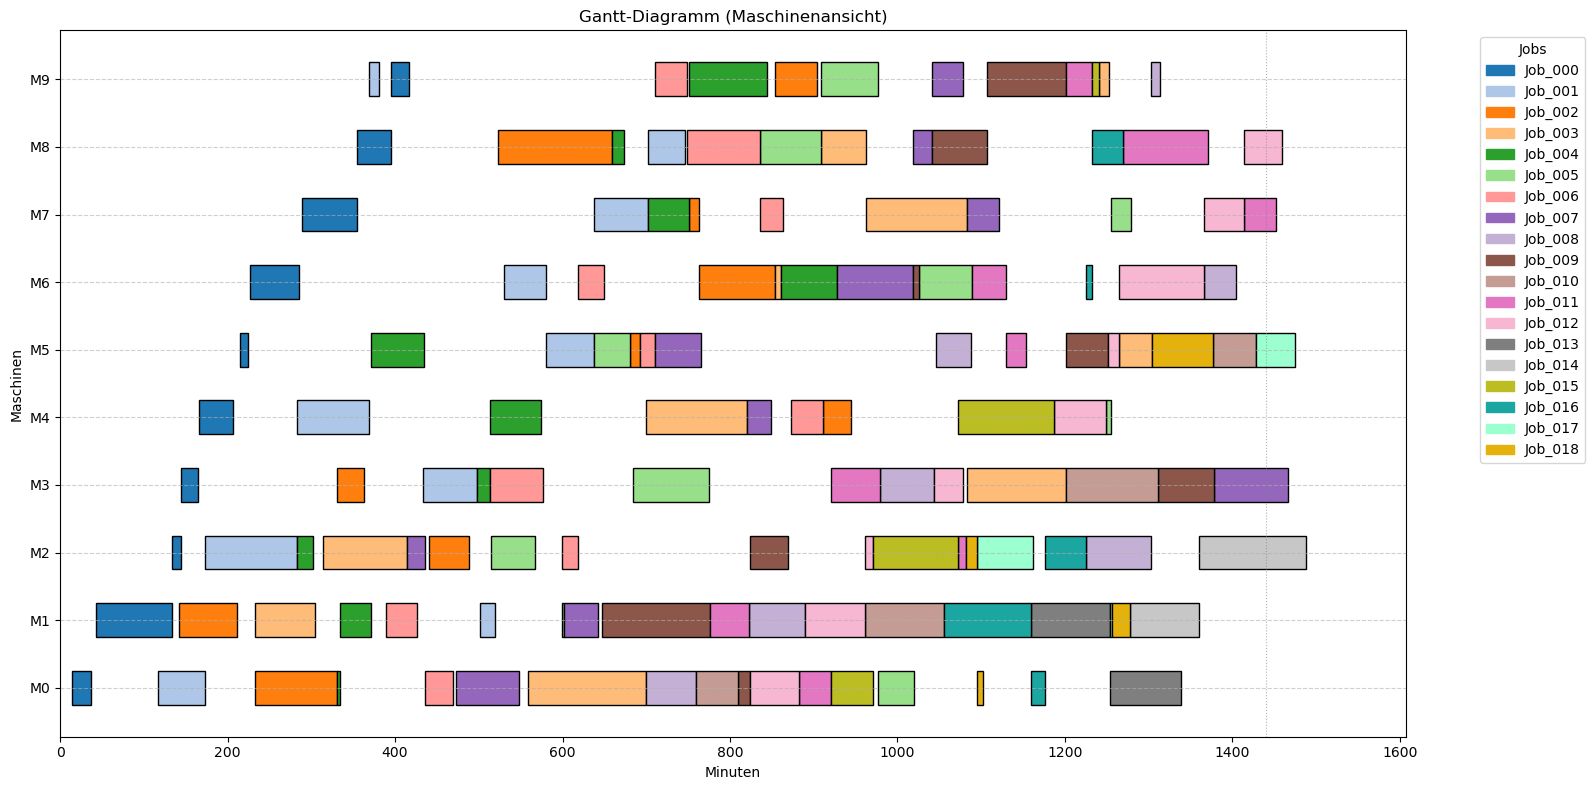

In [17]:
show.plot_gantt_machines(df_execution, duration_column = "Simulated Processing Time")

### 3) Verbliebe Jobs nach Tag 0

In [18]:
df_plan = df_plan0

df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_008,427.52,M7,1332.70,89,994.18,1421.70
1,Job_008,427.52,M4,1421.70,26,1020.18,1447.70
2,Job_008,427.52,M8,1447.70,74,1094.18,1521.70
3,Job_009,529.40,M4,1447.76,90,1008.36,1537.76
4,Job_009,529.40,M7,1537.76,45,1053.36,1582.76
...,...,...,...,...,...,...,...
548,Job_068,4210.59,M5,6927.36,10,2726.77,6937.36
549,Job_068,4210.59,M7,6937.36,12,2738.77,6949.36
550,Job_068,4210.59,M6,6949.36,89,2827.77,7038.36
551,Job_068,4210.59,M9,7038.36,45,2872.77,7083.36


In [19]:
jssp_data_rest = convert.get_jssp_from_schedule(df_rest)
show.print_jobs(jssp_data_rest)

Job_008:  [[7, 89], [4, 26], [8, 74]]
Job_009:  [[4, 90], [7, 45]]
Job_010:  [[2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_011:  [[4, 55]]
Job_012:  [[9, 21]]
Job_013:  [[3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_014:  [[0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_015:  [[3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_016:  [[9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_017:  [[3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_018:  [[3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_019:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_020:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_021:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_022:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
J

In [20]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
8,Job_008,427.52,3976.551324
9,Job_009,529.40,3739.579087
10,Job_010,582.94,4131.971324
11,Job_011,638.78,3111.806852
12,Job_012,647.75,2995.936555
...,...,...,...
64,Job_064,3749.15,6085.447002
65,Job_065,3907.00,7111.234311
66,Job_066,4061.64,6409.826555
67,Job_067,4110.12,7141.955805


## Day 1

In [21]:
jssp_data1, df_times1 = rp.update_new_day(jssp_data_rest, df_time_rest, instance, u_b_mmax= 0.75, generate_deadlines = True, deadlines_buffer_factor= 1.9)
show.print_jobs(jssp_data1)
df_times1

Job_008:  [[7, 89], [4, 26], [8, 74]]
Job_009:  [[4, 90], [7, 45]]
Job_010:  [[2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_011:  [[4, 55]]
Job_012:  [[9, 21]]
Job_013:  [[3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_014:  [[0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_015:  [[3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_016:  [[9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_017:  [[3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_018:  [[3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_019:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_020:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_021:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_022:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
J

,Job,Arrival,Deadline
0,Job_008,427.52,3976.551324
1,Job_009,529.40,3739.579087
2,Job_010,582.94,4131.971324
3,Job_011,638.78,3111.806852
4,Job_012,647.75,2995.936555
...,...,...,...
79,Job_087,5189.15,7525.447002
80,Job_088,5347.00,8551.234311
81,Job_089,5501.64,7849.826555
82,Job_090,5550.12,8581.955805


### 1) Rescheduling

In [22]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important


df_plan1 = re_ssv.solve_jssp_weighted_with_fixed_operations_fast(
    job_dict=jssp_data1,
    df_arrivals=df_times1,
    df_executed=df_execution_important,
    solver_time_limit=60*minutes,
    epsilon=0.6,
    arrival_column="Arrival",
    reschedule_start=1440
)

🔁 Starte schnelles Rescheduling ab t = 1440
🔹 84 Jobs erkannt
Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 3000
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/d1c8aca1af5d475986da3075e1e4ab09-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/d1c8aca1af5d475986da3075e1e4ab09-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 30353
MIP  d1c8aca1af5d475986da3075e1e4ab09-pulp has 61573 rows; 31220 cols; 183664 nonzeros; 30353 integer variables (30353 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [2e-04, 2e-03]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
61401 rows, 31126 cols, 183388 nonzeros  0s
31409 rows, 31125 cols, 93446 nonzeros  0s
31385 rows, 31113 cols, 93398 nonzeros  0s

Solving MIP model with:
   31385 rows
   31113 cols (30330 binary, 0 integer, 0 implied int., 783

In [23]:
print(f"Final End:{max(df_plan1.End)}")
df_plan1

Final End:8916.4


,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_091,5650.59,M1,7851.80,91,2292.21,7942.80
1,Job_091,5650.59,M0,8115.40,85,2549.81,8200.40
2,Job_091,5650.59,M3,8524.40,39,2912.81,8563.40
3,Job_091,5650.59,M2,8563.40,74,2986.81,8637.40
4,Job_091,5650.59,M8,8637.40,90,3076.81,8727.40
...,...,...,...,...,...,...,...
778,Job_009,529.40,M4,1440.00,90,1000.60,1530.00
779,Job_009,529.40,M7,1530.00,45,1045.60,1575.00
780,Job_008,427.52,M7,1575.60,89,1237.08,1664.60
781,Job_008,427.52,M4,1664.60,26,1263.08,1690.60


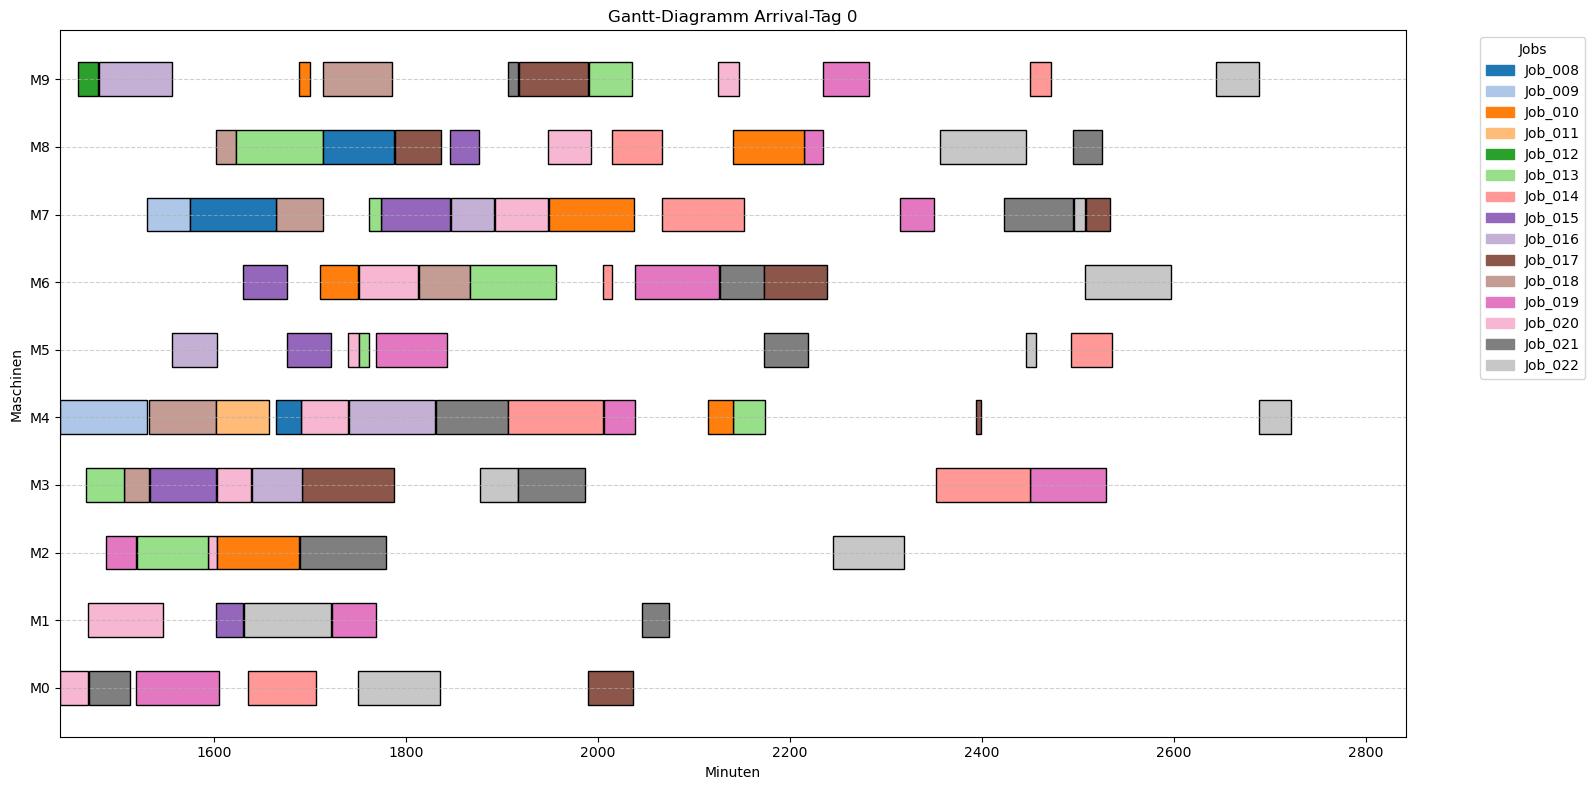

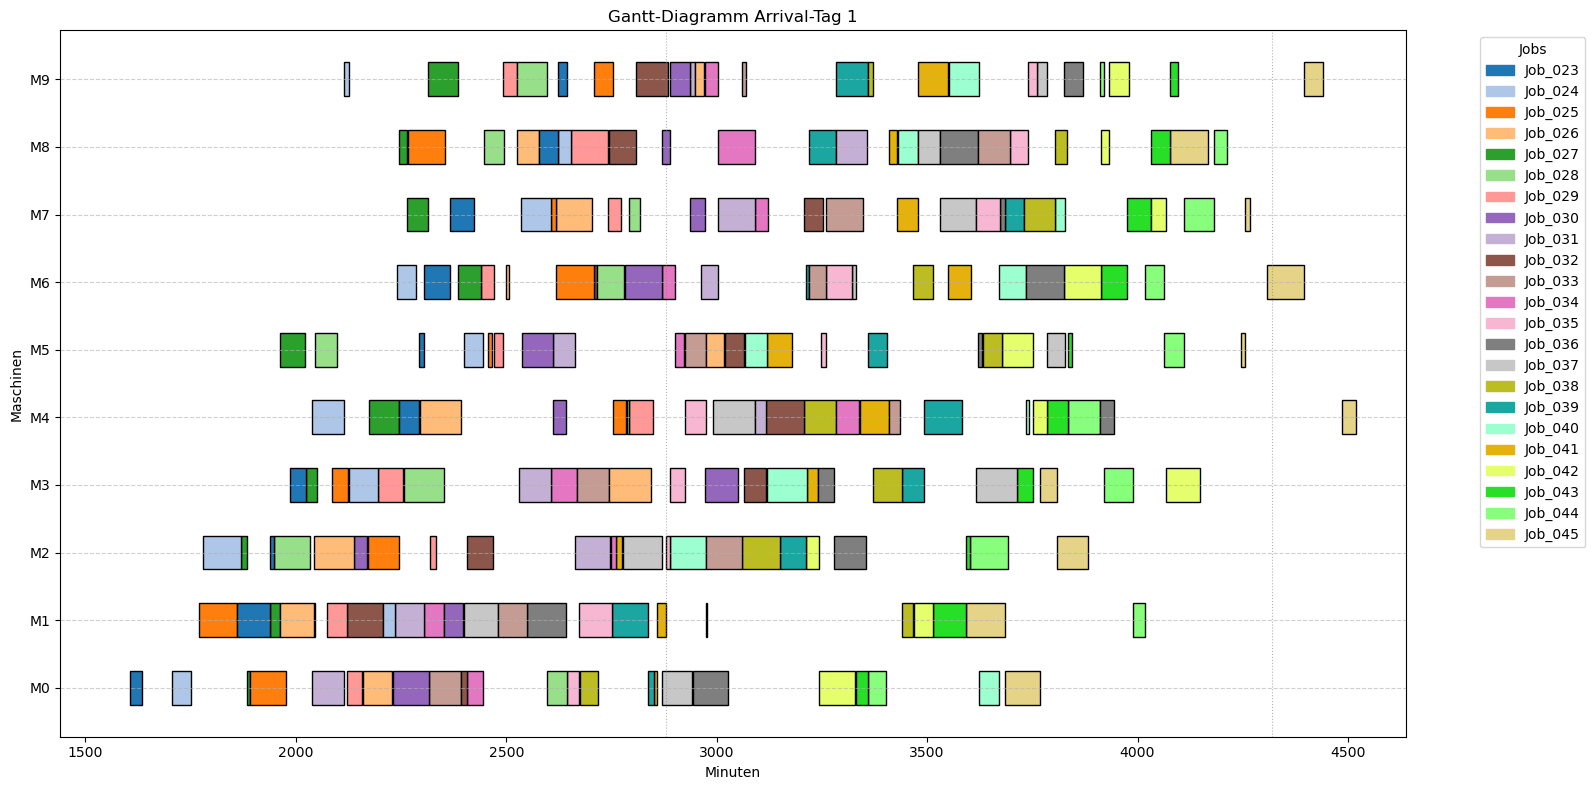

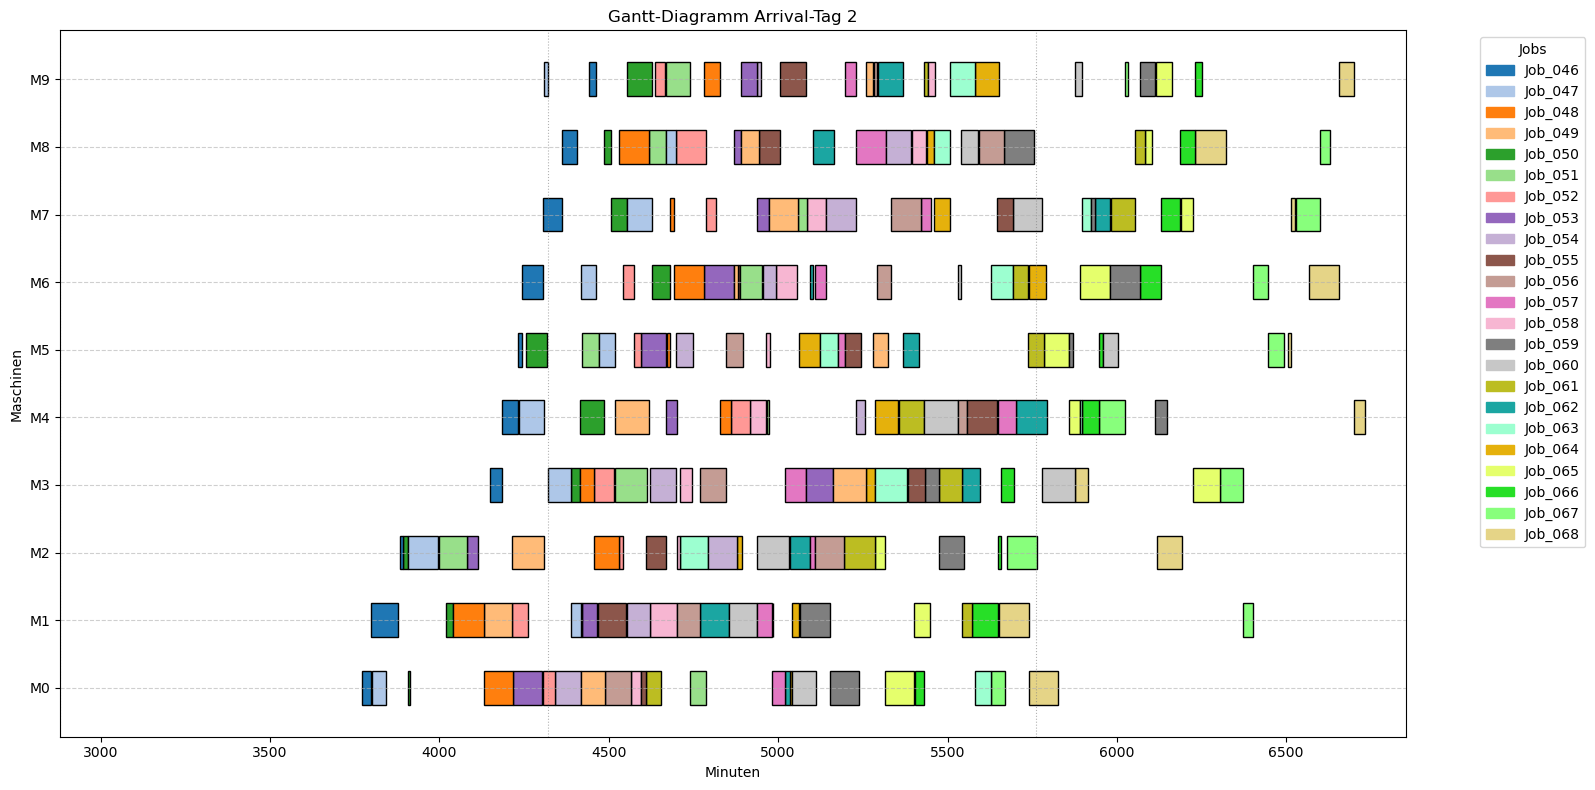

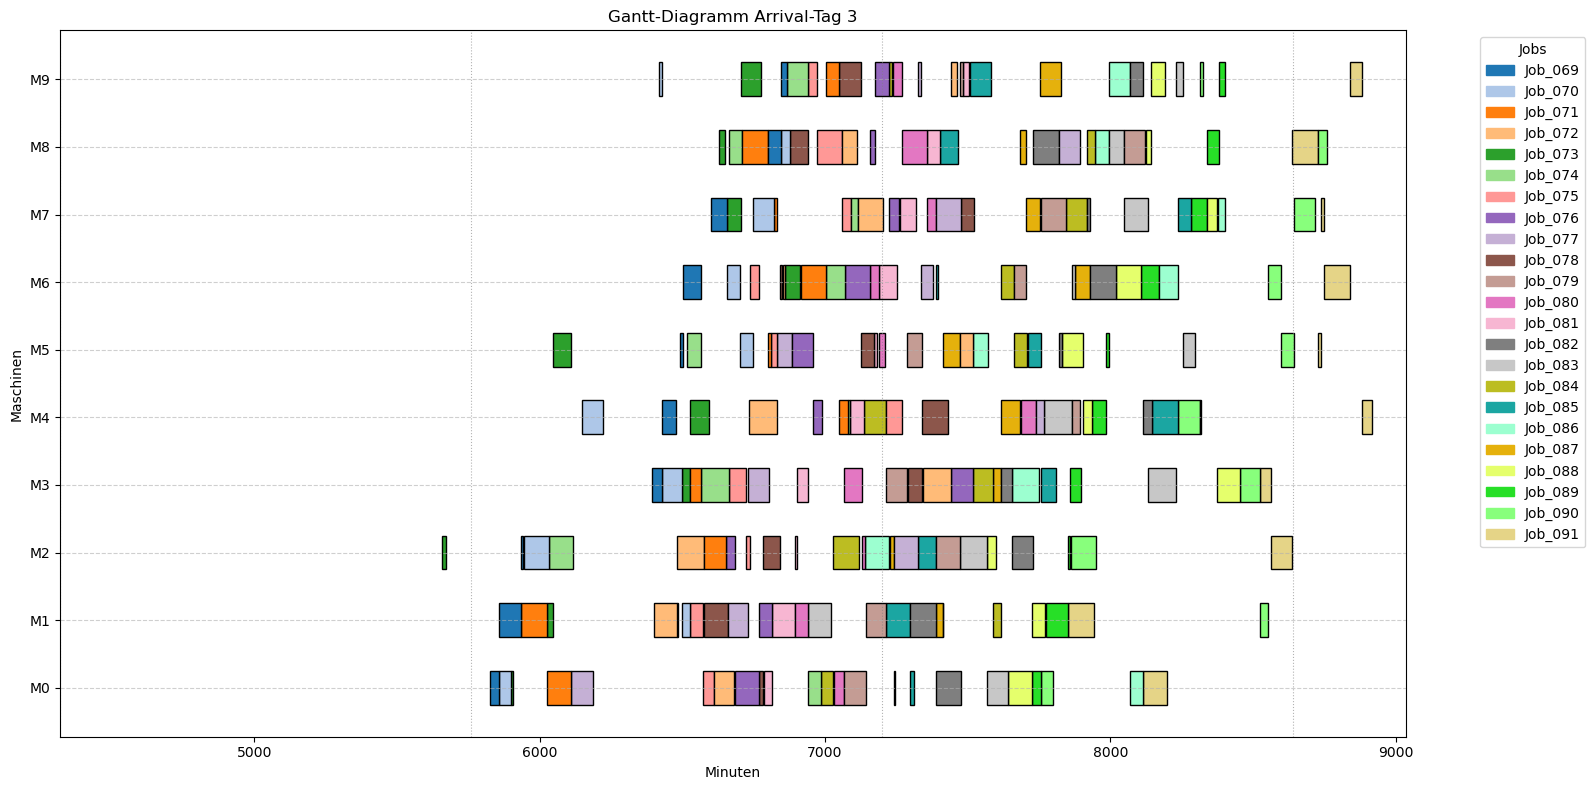

In [24]:
df = df_plan1

block = 1440                                        
for idx, part_df in df.groupby(df['Arrival'] // block, sort=True):
    show.plot_gantt_machines(part_df, f"Gantt-Diagramm Arrival-Tag {int(idx)}")

### 2) Simulation für Tag 1

In [25]:
day_start = 1440
day_end = day_start + 1440

filt = (df_plan1["Start"] >=  day_start) & (df_plan1["Start"] < day_end)
df_schedule_1 = df_plan1[filt]
df_schedule_1

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
500,Job_041,2309.15,M2,2761.60,14,466.45,2775.60
501,Job_041,2309.15,M0,2851.00,6,547.85,2857.00
502,Job_041,2309.15,M1,2857.00,22,569.85,2879.00
520,Job_039,2219.36,M1,2752.40,85,618.04,2837.40
521,Job_039,2219.36,M0,2837.40,13,631.04,2850.40
...,...,...,...,...,...,...,...
778,Job_009,529.40,M4,1440.00,90,1000.60,1530.00
779,Job_009,529.40,M7,1530.00,45,1045.60,1575.00
780,Job_008,427.52,M7,1575.60,89,1237.08,1664.60
781,Job_008,427.52,M4,1664.60,26,1263.08,1690.60


In [26]:
simulation = ProductionDaySimulation(df_schedule_1, vc=0.25)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_009 started on M4
[24:00:00] Job_020 started on M0
[24:18:55] Job_012 started on M9
[24:27:21] Job_013 started on M3
[24:47:07] Job_012 finished on M9 (after 28 minutes 13 seconds)
[24:47:07] Job_016 started on M9
[24:48:03] Job_019 started on M2
[24:51:40] Job_013 finished on M3 (after 24 minutes 19 seconds)
[24:59:02] Job_020 finished on M0 (after 59 minutes 02 seconds)
[24:59:02] Job_021 started on M0
[24:59:02] Job_020 started on M1
[25:06:57] Job_018 started on M3
[25:19:34] Job_019 finished on M2 (after 31 minutes 31 seconds)
[25:19:39] Job_013 started on M2
[25:23:57] Job_018 finished on M3 (after 17 minutes)
[25:33:33] Job_015 started on M3
[25:43:28] Job_021 finished on M0 (after 44 minutes 26 seconds)
[25:43:28] Job_019 started on M0
[25:47:30] Job_016 finished on M9 (after 60 minutes 23 seconds)
[25:48:29] Job_020 finished on M1 (after 49 minutes 27 seconds)
[25:56:31] Job_016 started on M5
[25:59:24] Job_009 finished on M4 (after 119 minutes 24 seconds)
[25:5

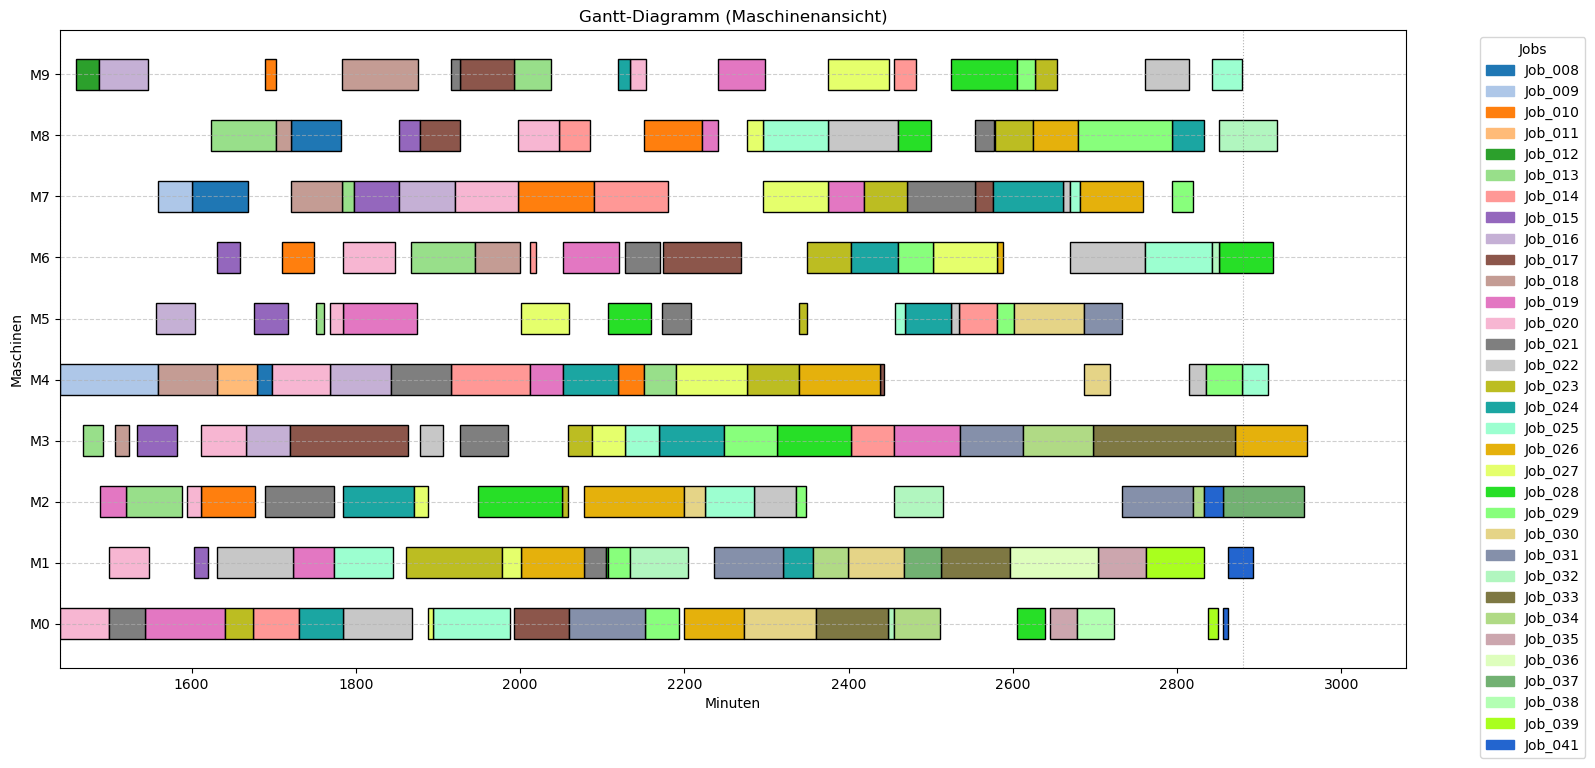

In [27]:
show.plot_gantt_machines(df_execution, duration_column = "Simulated Processing Time")

### 3) Verbleibene Jobs nach Tag 1

In [28]:
df_plan = df_plan1

df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_026,1632.34,M9,2948.6,22,1338.26,2970.6
1,Job_026,1632.34,M5,2975.2,43,1385.86,3018.2
2,Job_028,1756.00,M4,2786.2,6,1036.20,2792.2
3,Job_028,1756.00,M7,2792.2,25,1061.20,2817.2
4,Job_030,1849.92,M6,2781.4,88,1019.48,2869.4
...,...,...,...,...,...,...,...
586,Job_091,5650.59,M5,8727.4,10,3086.81,8737.4
587,Job_091,5650.59,M7,8737.4,12,3098.81,8749.4
588,Job_091,5650.59,M6,8749.4,89,3187.81,8838.4
589,Job_091,5650.59,M9,8838.4,45,3232.81,8883.4


In [29]:
jssp_data_rest = convert.get_jssp_from_schedule(df_rest)
show.print_jobs(jssp_data_rest)

Job_026:  [[9, 22], [5, 43]]
Job_028:  [[4, 6], [7, 25]]
Job_030:  [[6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_031:  [[9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_032:  [[9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_033:  [[5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_034:  [[6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_035:  [[2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_036:  [[0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_037:  [[0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_038:  [[2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_039:  [[2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_040:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_041:  [[5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_042:  [[2, 31], [0, 86], [1, 

In [30]:
df_times = df_times1

allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
18,Job_026,1632.34,5526.168337
20,Job_028,1756.00,4704.608939
22,Job_030,1849.92,5054.154311
23,Job_031,1867.52,5416.551324
24,Job_032,1969.40,5179.579087
...,...,...,...
79,Job_087,5189.15,7525.447002
80,Job_088,5347.00,8551.234311
81,Job_089,5501.64,7849.826555
82,Job_090,5550.12,8581.955805


## Day 2

In [31]:
jssp_data2, df_times2 = rp.update_new_day(jssp_data_rest, df_time_rest, instance, u_b_mmax= 0.75, generate_deadlines = True, deadlines_buffer_factor= 1.9)
show.print_jobs(jssp_data2)
df_times2

Job_026:  [[9, 22], [5, 43]]
Job_028:  [[4, 6], [7, 25]]
Job_030:  [[6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_031:  [[9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_032:  [[9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_033:  [[5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_034:  [[6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_035:  [[2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_036:  [[0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_037:  [[0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_038:  [[2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_039:  [[2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_040:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_041:  [[5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_042:  [[2, 31], [0, 86], [1, 

,Job,Arrival,Deadline
0,Job_026,1632.34,5526.168337
1,Job_028,1756.00,4704.608939
2,Job_030,1849.92,5054.154311
3,Job_031,1867.52,5416.551324
4,Job_032,1969.40,5179.579087
...,...,...,...
82,Job_110,6629.15,8965.447002
83,Job_111,6787.00,9991.234311
84,Job_112,6941.64,9289.826555
85,Job_113,6990.12,10021.955805


### 1) Rescheduling

In [32]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 2880]
df_execution_important

,Job,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
122,Job_025,1581.78,M4,2879.16,31.80,1329.18,2910.96
130,Job_026,1632.34,M3,2870.27,88.45,1326.38,2958.72
148,Job_028,1756.00,M6,2851.53,65.36,1160.89,2916.89
173,Job_032,1969.40,M8,2851.53,70.38,952.51,2921.91
185,Job_037,2127.70,M2,2856.03,98.63,826.96,2954.66
191,Job_041,2309.15,M1,2862.08,30.24,583.17,2892.32


In [34]:
df_plan2 = re_ssv.solve_jssp_weighted_with_fixed_operations_fast(
    job_dict=jssp_data2,
    df_arrivals=df_times2,
    df_executed=df_execution_important,
    solver_time_limit=60*minutes,
    epsilon=0.6,
    arrival_column="Arrival",
    reschedule_start=2880
)

🔁 Starte schnelles Rescheduling ab t = 2880
🔹 87 Jobs erkannt
Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 3000
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/e64a67a30126400fbbac16df3b0c5cea-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/e64a67a30126400fbbac16df3b0c5cea-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 33445
MIP  e64a67a30126400fbbac16df3b0c5cea-pulp has 67798 rows; 34353 cols; 202239 nonzeros; 33445 integer variables (33445 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e-04, 6e-04]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
67616 rows, 34250 cols, 201938 nonzeros  0s
35267 rows, 34249 cols, 104941 nonzeros  0s
35225 rows, 34228 cols, 104857 nonzeros  0s

Solving MIP model with:
   35225 rows
   34228 cols (33407 binary, 0 integer, 0 implied int., 8

In [35]:
print(f"Final End:{max(df_plan2.End)}")
df_plan2

Final End:10096.2


,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_114,7090.59,M1,9353.20,91,2353.61,9444.20
1,Job_114,7090.59,M0,9619.20,85,2613.61,9704.20
2,Job_114,7090.59,M3,9704.20,39,2652.61,9743.20
3,Job_114,7090.59,M2,9743.20,74,2726.61,9817.20
4,Job_114,7090.59,M8,9817.20,90,2816.61,9907.20
...,...,...,...,...,...,...,...
816,Job_030,1849.92,M3,3341.06,79,1570.14,3420.06
817,Job_028,1756.00,M4,2916.89,6,1166.89,2922.89
818,Job_028,1756.00,M7,2922.89,25,1191.89,2947.89
819,Job_026,1632.34,M9,2958.72,22,1348.38,2980.72


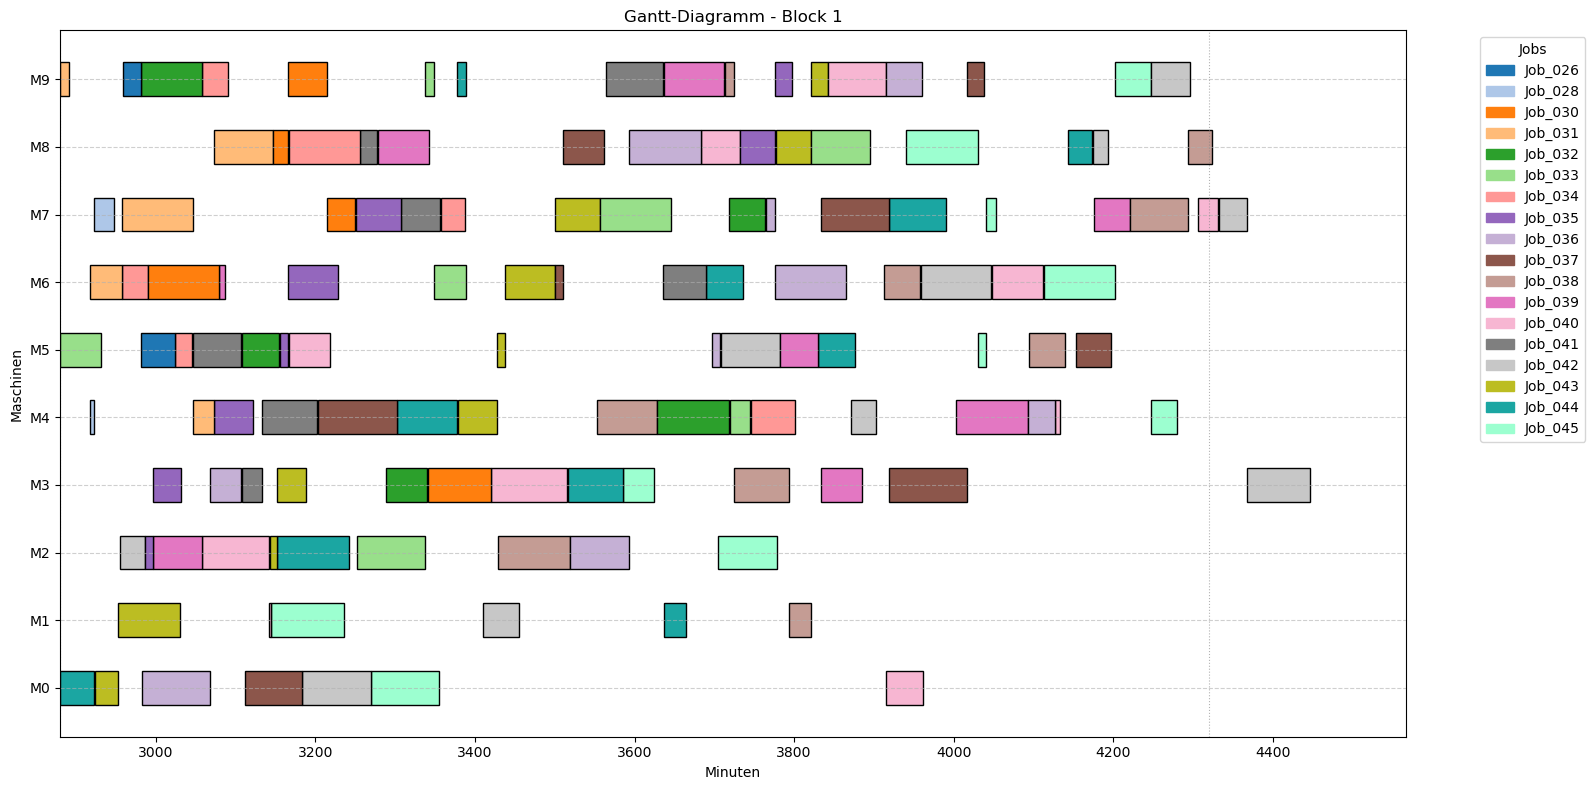

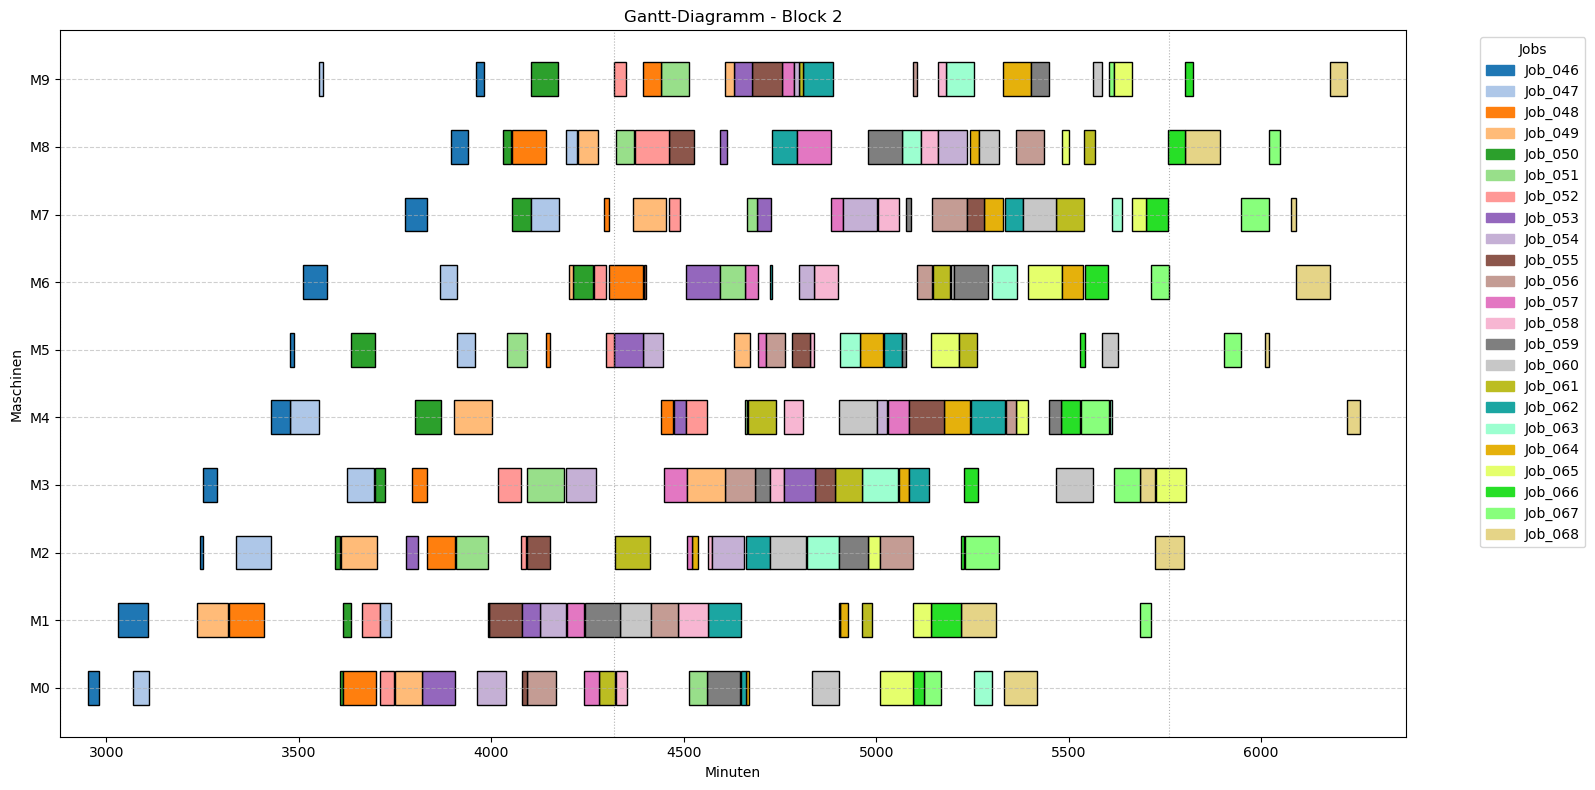

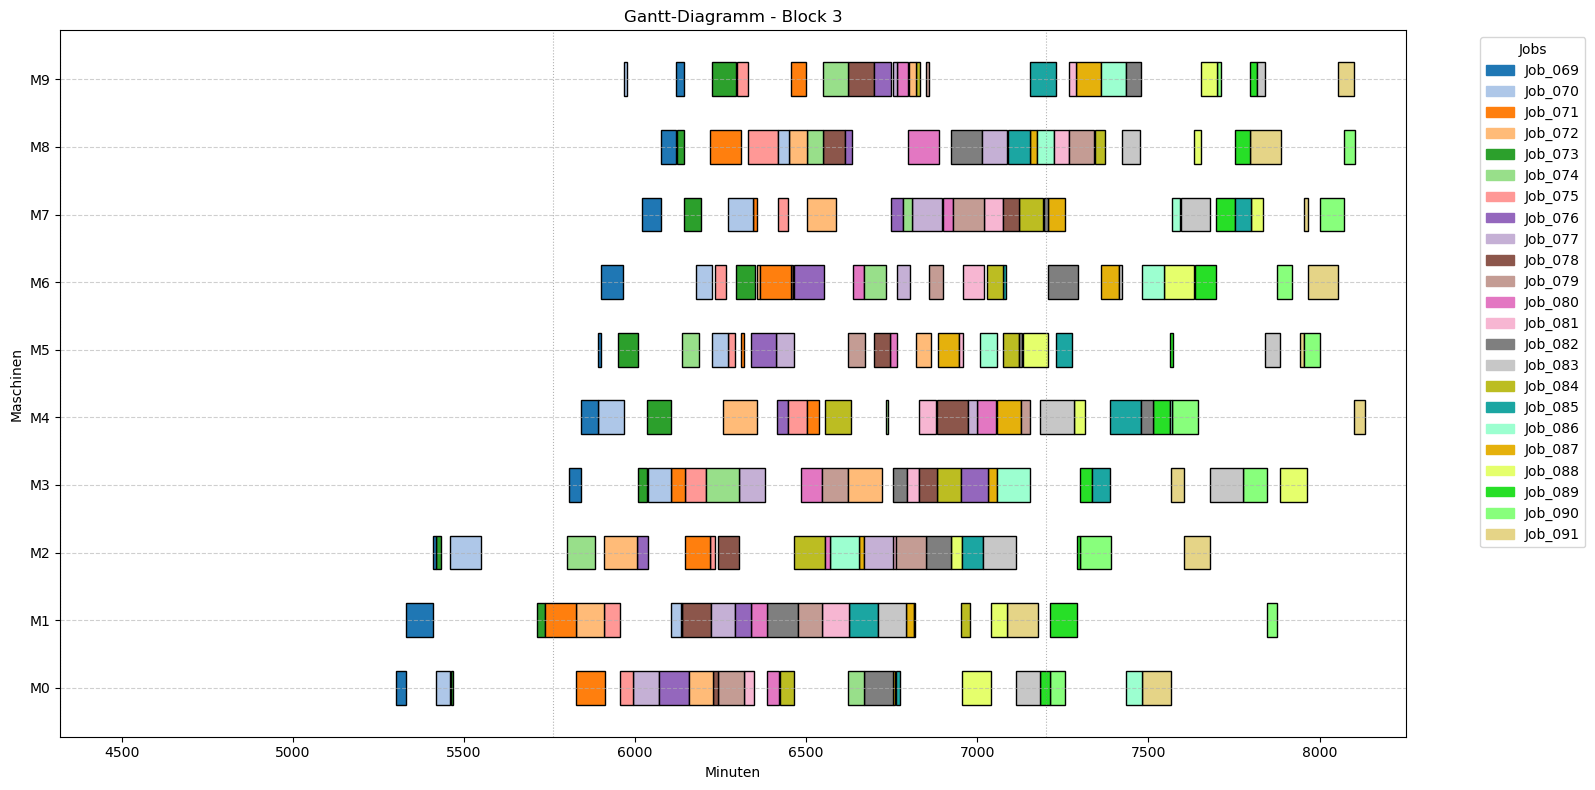

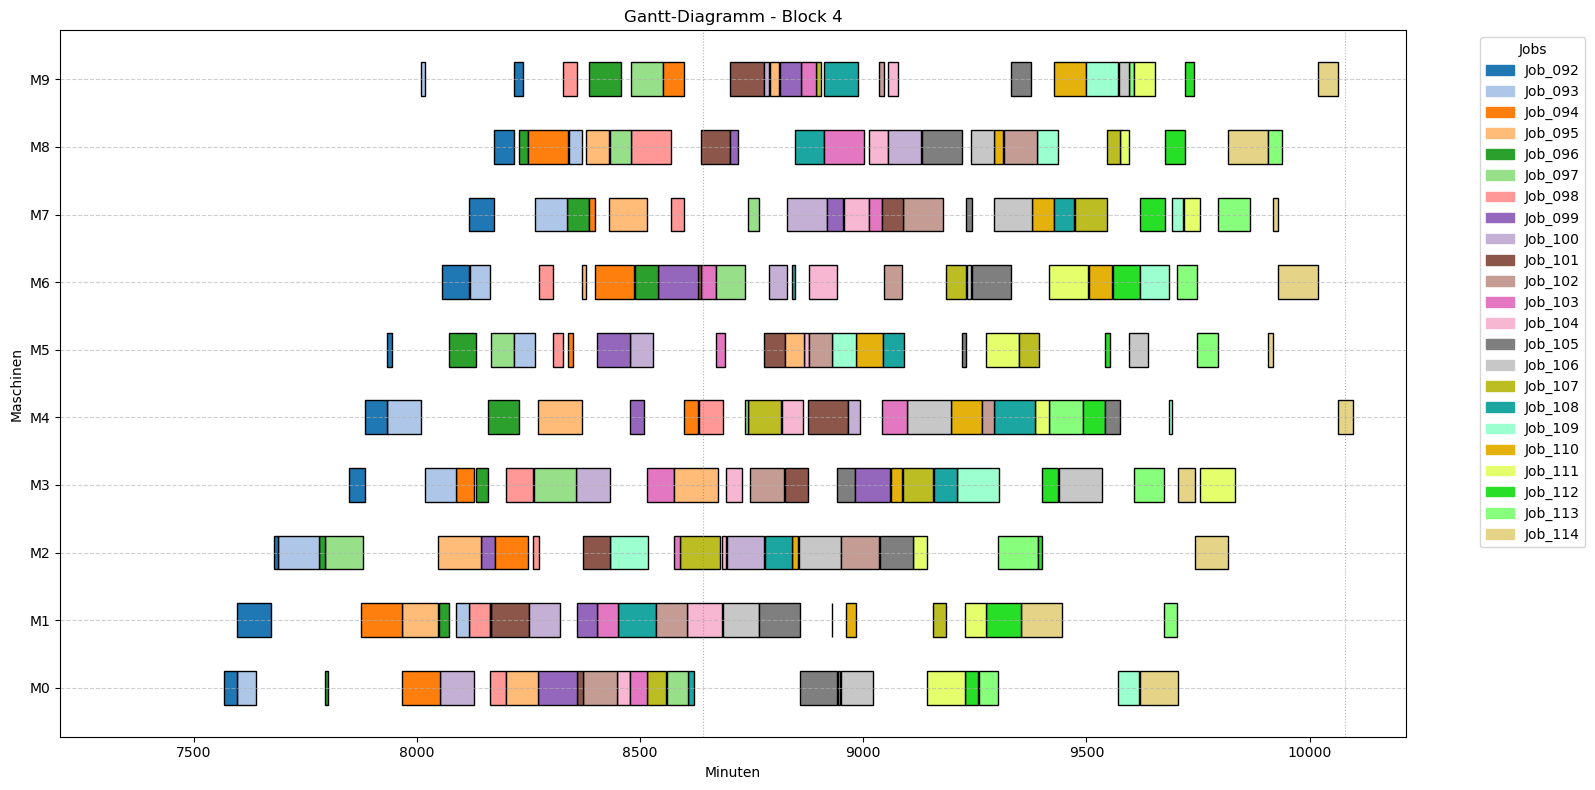

In [36]:
df = df_plan2

block = 1440                                        
for idx, part_df in df.groupby(df['Arrival'] // block, sort=True):
    show.plot_gantt_machines(part_df, f"Gantt-Diagramm - Block {int(idx)}")

### 2) Simulation für Tag 2

In [38]:
day_start = 2880
day_end = day_start + 1440

filt = (df_plan2["Start"] >=  day_start) & (df_plan2["Start"] < day_end)
df_schedule_2 = df_plan2[filt]
df_schedule_2

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
530,Job_061,3590.50,M0,4279.40,43,731.90,4322.40
550,Job_059,3565.32,M1,4242.40,91,768.08,4333.40
570,Job_057,3518.78,M1,4195.80,46,723.02,4241.80
571,Job_057,3518.78,M0,4241.80,37,760.02,4278.80
580,Job_056,3462.94,M0,4092.60,76,705.66,4168.60
...,...,...,...,...,...,...,...
816,Job_030,1849.92,M3,3341.06,79,1570.14,3420.06
817,Job_028,1756.00,M4,2916.89,6,1166.89,2922.89
818,Job_028,1756.00,M7,2922.89,25,1191.89,2947.89
819,Job_026,1632.34,M9,2958.72,22,1348.38,2980.72


In [39]:
simulation = ProductionDaySimulation(df_schedule_2, vc=0.25)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[48:00:00] Job_031 started on M9
[48:00:00] Job_033 started on M5
[48:00:00] Job_044 started on M0
[48:09:40] Job_031 finished on M9 (after 09 minutes 41 seconds)
[48:31:48] Job_033 finished on M5 (after 31 minutes 49 seconds)
[48:36:53] Job_028 started on M4
[48:37:29] Job_031 started on M6
[48:44:50] Job_028 finished on M4 (after 07 minutes 58 seconds)
[48:44:50] Job_028 started on M7
[48:52:31] Job_044 finished on M0 (after 52 minutes 32 seconds)
[48:52:31] Job_043 started on M0
[49:00:41] Job_028 finished on M7 (after 15 minutes 51 seconds)
[49:15:15] Job_042 started on M2
[49:18:43] Job_026 started on M9
[49:26:11] Job_043 finished on M0 (after 33 minutes 40 seconds)
[49:26:11] Job_046 started on M0
[49:26:11] Job_043 started on M1
[49:35:34] Job_026 finished on M9 (after 16 minutes 51 seconds)
[49:40:43] Job_026 started on M5
[49:41:19] Job_032 started on M9
[49:44:19] Job_031 finished on M6 (after 66 minutes 50 seconds)
[49:44:19] Job_034 started on M6
[49:44:19] Job_031 started

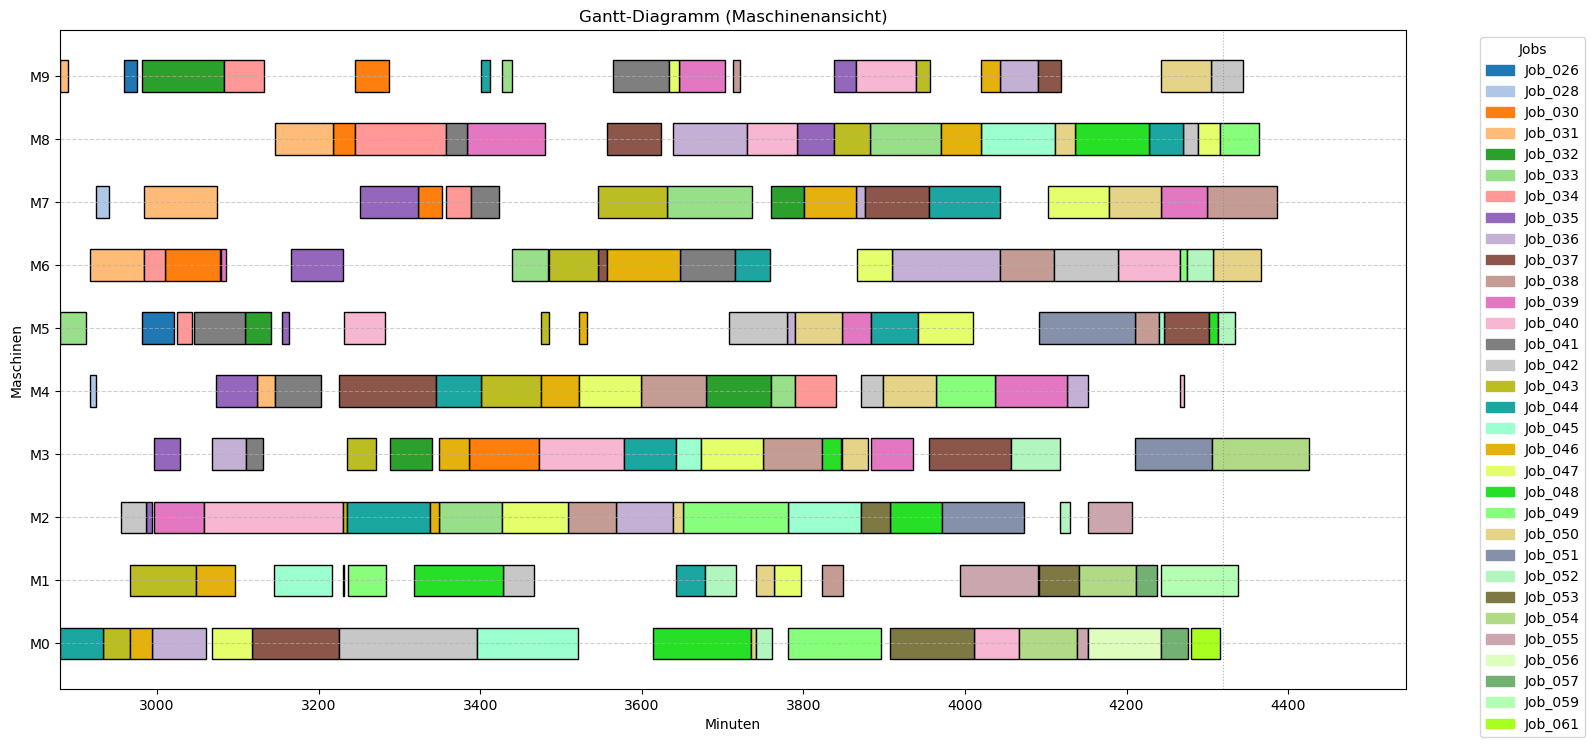

In [40]:
show.plot_gantt_machines(df_execution, duration_column = "Simulated Processing Time")

### 3) Verbleibene Jobs nach Tag 2

In [41]:
df_plan = df_plan2

df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_038,2150.50,M8,4293.26,30,2172.76,4323.26
1,Job_040,2238.47,M7,4306.46,25,2092.99,4331.46
2,Job_042,2467.00,M7,4332.06,36,1901.06,4368.06
3,Job_042,2467.00,M3,4368.06,79,1980.06,4447.06
4,Job_045,2770.59,M7,4040.86,12,1282.27,4052.86
...,...,...,...,...,...,...,...
627,Job_114,7090.59,M5,9907.20,10,2826.61,9917.20
628,Job_114,7090.59,M7,9917.20,12,2838.61,9929.20
629,Job_114,7090.59,M6,9929.20,89,2927.61,10018.20
630,Job_114,7090.59,M9,10018.20,45,2972.61,10063.20


In [42]:
jssp_data_rest = convert.get_jssp_from_schedule(df_rest)
show.print_jobs(jssp_data_rest)

Job_038:  [[8, 30]]
Job_040:  [[7, 25]]
Job_042:  [[7, 36], [3, 79]]
Job_045:  [[7, 12], [6, 89], [9, 45], [4, 33]]
Job_048:  [[7, 12], [6, 89], [9, 45], [4, 33]]
Job_049:  [[7, 85], [3, 98], [9, 22], [5, 43]]
Job_051:  [[8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_052:  [[9, 32], [8, 89], [7, 30], [4, 55]]
Job_053:  [[5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_054:  [[5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_055:  [[6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_056:  [[1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_057:  [[3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_058:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_059:  [[0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_060:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], 

In [43]:
df_times = df_times1

allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
30,Job_038,2150.50,5182.335805
32,Job_040,2238.47,5187.078939
34,Job_042,2467.00,5671.234311
37,Job_045,2770.59,6147.222818
40,Job_048,3021.78,6398.412818
...,...,...,...
79,Job_087,5189.15,7525.447002
80,Job_088,5347.00,8551.234311
81,Job_089,5501.64,7849.826555
82,Job_090,5550.12,8581.955805


## Save

In [44]:
df_plan0.to_csv("data/08a_plan0.csv", index = False)
df_plan1.to_csv("data/08a_plan1.csv", index = False)
df_plan2.to_csv("data/08a_plan2.csv", index = False)